In [1]:
from cognipy.ontology import Ontology
from cognipy.ontology import CQL
from cognipy.ontology import ABoxBatch
from cognipy.ontology import encode_string_for_graph_label
from cognipy.edit import CnlEditBox
from cognipy.edit import CnlQueryForConcept

import random
import textwrap
import numpy as np
import pandas as pd
import pickle

def graph_attribute_formatter(val):
    if isinstance(val,list) or isinstance(val,set):
        return " | ".join(list(map(lambda i:encode_string_for_graph_label(graph_attribute_formatter(i)),val)))
    elif isinstance(val,dict):
        return " | ".join(list(map(lambda i:i[0]+" : "+encode_string_for_graph_label(graph_attribute_formatter(i[1])),val.items())))
    else:
        return encode_string_for_graph_label(textwrap.fill(str(val),40))

from pint import UnitRegistry
ureg = UnitRegistry()
Q = ureg.Quantity

def Qstr(a):
    return "Q('"+str(a)+"')"
Q.__repr__=Qstr    


In [2]:
parts_editors={}

parts_editors['01']=CnlEditBox('border_cross_quarantine.encnl')
parts_editors['02']=CnlEditBox('face_cover.encnl')
parts_editors['03']=CnlEditBox('countries.encnl')
parts_editors['04']=CnlEditBox('lockdown.encnl')
parts_editors['05']=CnlEditBox('mass_coronavirus_testing.encnl')


<IPython.core.display.Javascript object>

In [3]:
def buildOntology(parts_editors,test_editor=None):
    return Ontology("cnl/string",
                    "\n\n".join(k.getvalue() for k in parts_editors.values())+('' if test_editor is None else test_editor.getvalue()), 
                    evaluator = lambda e:eval(e,globals(),locals()), 
                    graph_attribute_formatter = graph_attribute_formatter)

onto=buildOntology(parts_editors)

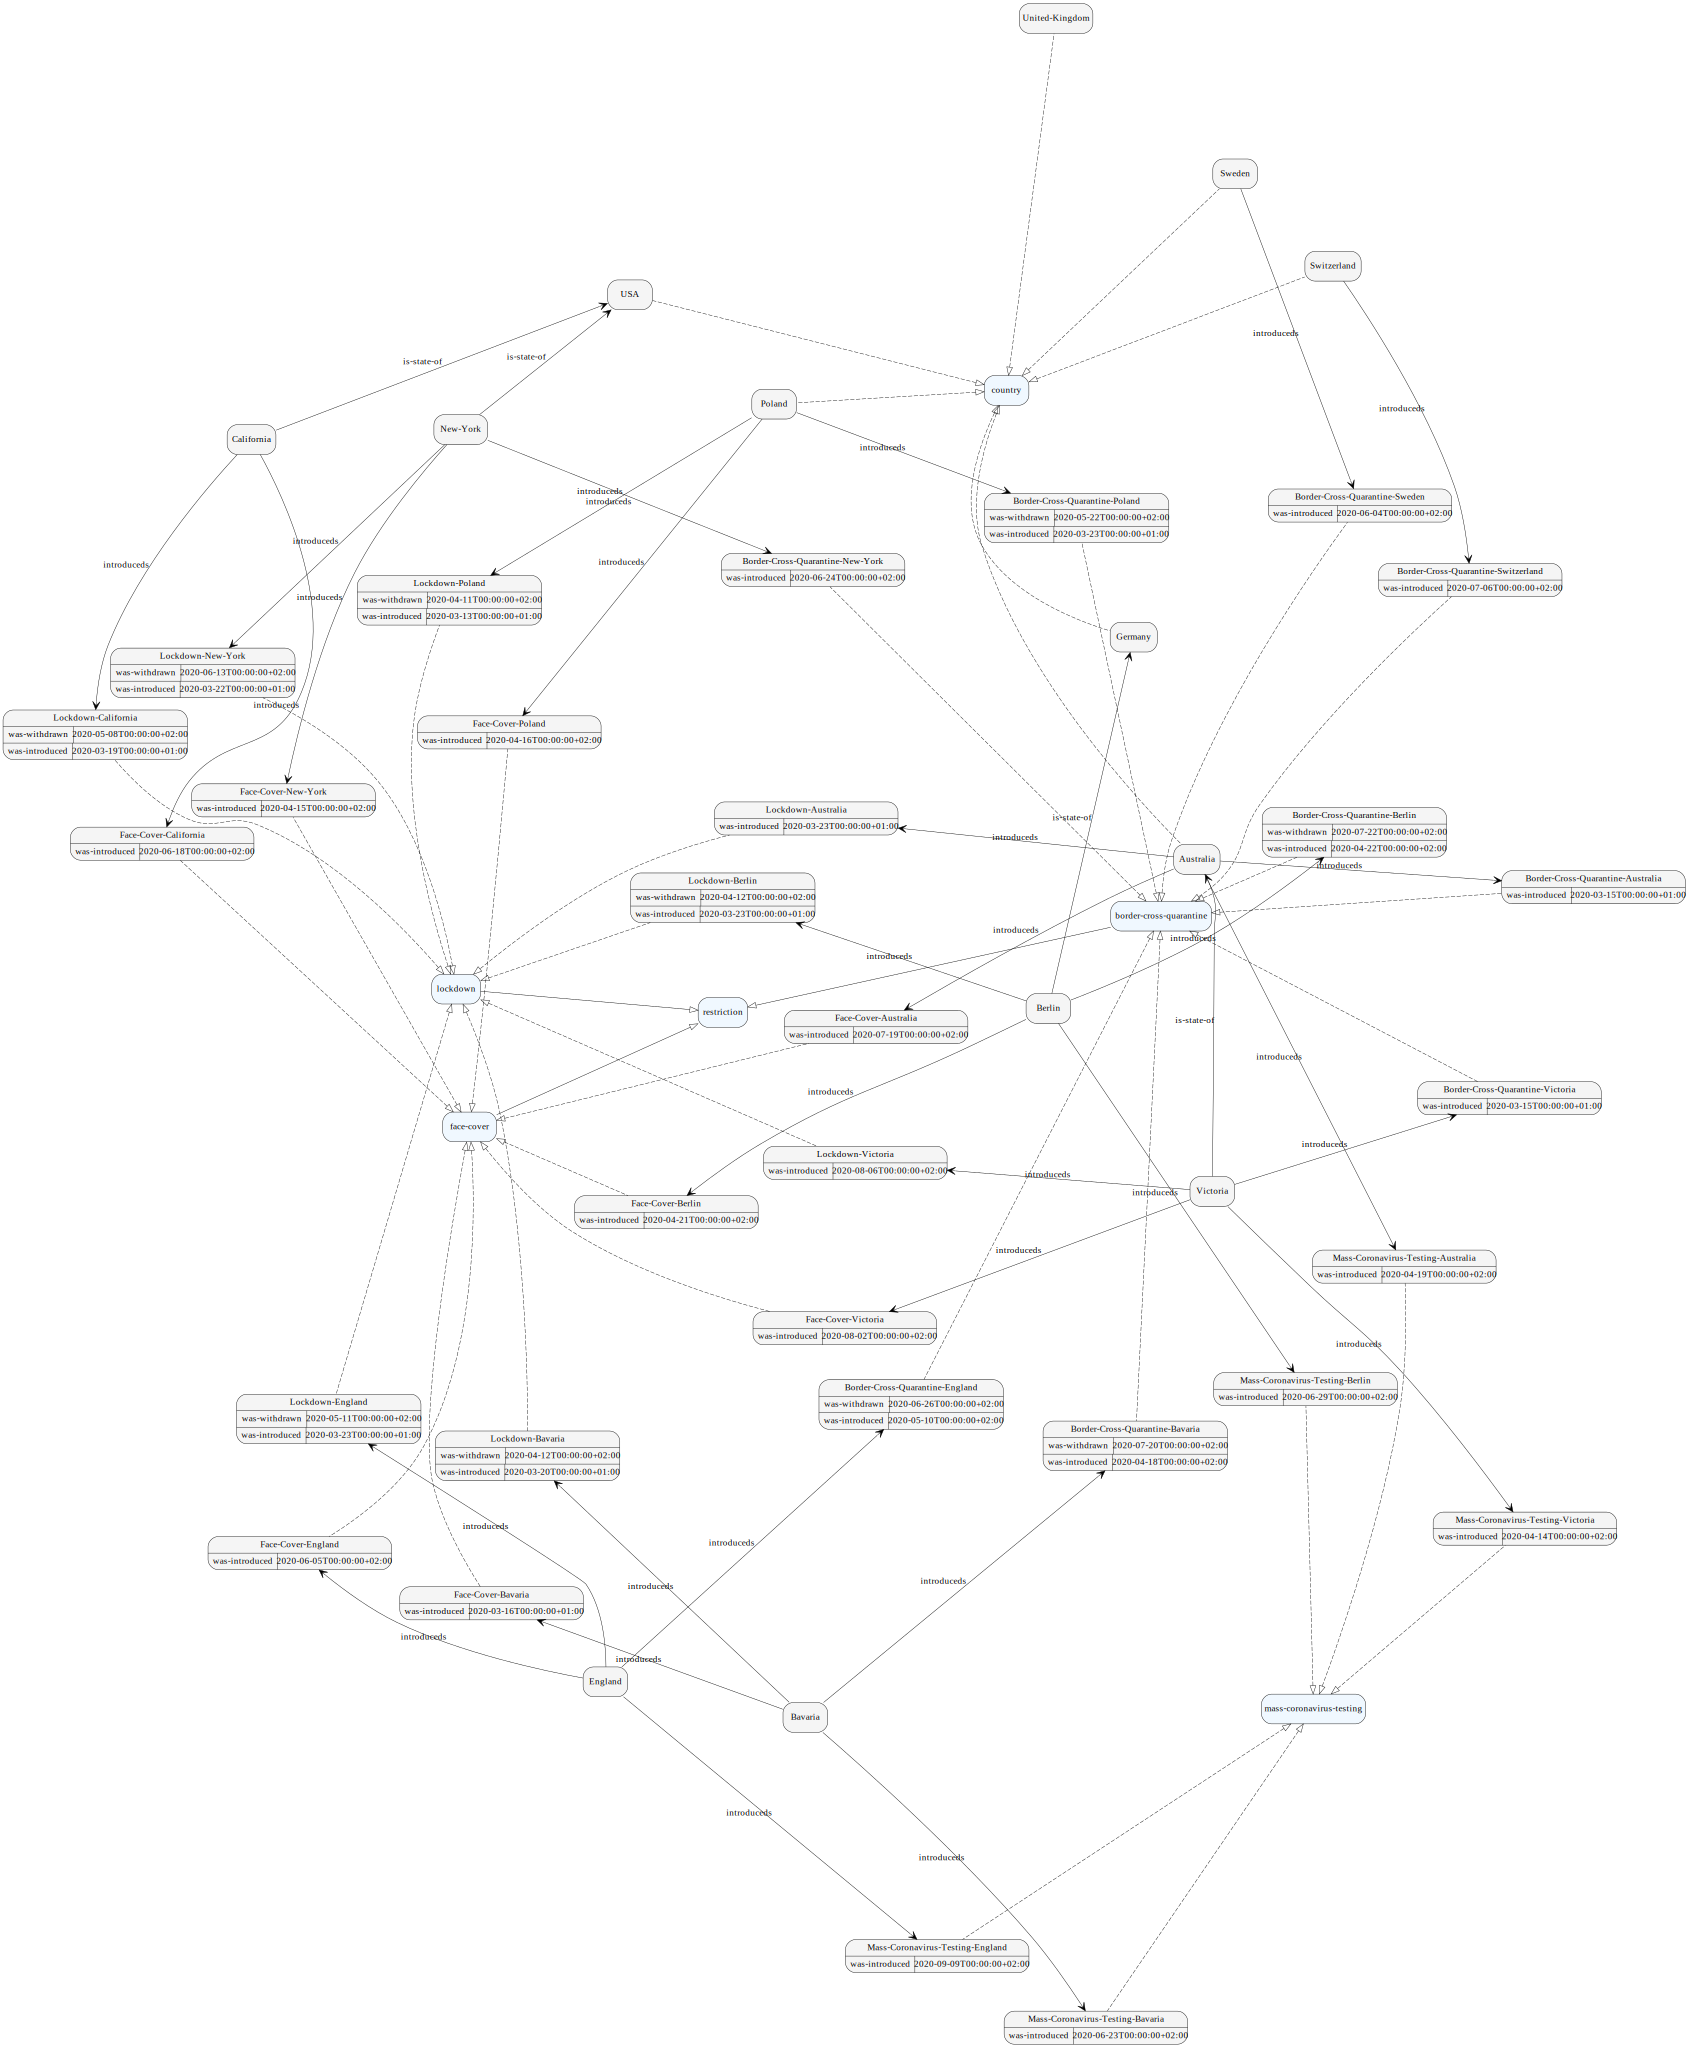

In [4]:


onto.draw_graph(layout='force directed')

In [5]:
onto.select_instances_of("country")


,Instance,introduceds
0,Switzerland,Border-Cross-Quarantine-Switzerland
1,USA,None
2,Australia,"[Mass-Coronavirus-Testing-Australia, Lockdown-..."
3,United-Kingdom,None
4,Sweden,Border-Cross-Quarantine-Sweden
5,Germany,None
6,Poland,"[Lockdown-Poland, Face-Cover-Poland, Border-Cr..."


In [6]:
df=onto.sparql_query(CQL("""select ?Country ?Restriction ?Date{
                            ?Country rdf:type <country>. 
                            ?Restriction rdf:type <restriction>. 
                            ?Country <introduceds> ?Restriction. 
                            ?Restriction <was-introduced> ?Date.
                        }"""))

In [7]:
df['Date'] = pd.to_datetime(df['Date']).apply(lambda x: x.strftime('%m/%d/%y'))
df



,Country,Restriction,Date
0,Switzerland,Border-Cross-Quarantine-Switzerland,07/06/20
1,Australia,Lockdown-Australia,03/23/20
2,Australia,Face-Cover-Australia,07/19/20
3,Australia,Border-Cross-Quarantine-Australia,03/15/20
4,Sweden,Border-Cross-Quarantine-Sweden,06/04/20
5,Poland,Lockdown-Poland,03/13/20
6,Poland,Face-Cover-Poland,04/16/20
7,Poland,Border-Cross-Quarantine-Poland,03/23/20


In [8]:
covid_data = pd.read_csv('cowid-covid-data.csv')

countries = ['Switzerland','USA','Australia','United Kingdom','Sweden','Sweden','Germany','Poland']

covid_data = covid_data.loc[covid_data["Country/Region"].isin(countries)]
covid_data



,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,9/27/20,9/28/20,9/29/20,9/30/20,10/1/20,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20
8,Australian Capital Territory,Australia,-35.473500,149.012400,0,0,0,0,0,0,...,113,113,113,113,113,113,113,113,113,113
9,New South Wales,Australia,-33.868800,151.209300,0,0,0,0,3,4,...,4218,4220,4224,4227,4231,4232,4234,4235,4246,4249
10,Northern Territory,Australia,-12.463400,130.845600,0,0,0,0,0,0,...,33,33,33,33,33,33,33,33,33,33
11,Queensland,Australia,-27.469800,153.025100,0,0,0,0,0,0,...,1157,1157,1157,1157,1160,1160,1160,1160,1160,1160
12,South Australia,Australia,-34.928500,138.600700,0,0,0,0,0,0,...,468,468,468,468,468,470,470,471,471,472
13,Tasmania,Australia,-42.882100,147.327200,0,0,0,0,0,0,...,230,230,230,230,230,230,230,230,230,230
14,Victoria,Australia,-37.813600,144.963100,0,0,0,0,1,1,...,20149,20158,20169,20183,20189,20197,20209,20220,20233,20237
15,Western Australia,Australia,-31.950500,115.860500,0,0,0,0,0,0,...,676,676,684,685,685,686,686,686,687,687
130,NaN,Germany,51.165691,10.451526,0,0,0,0,0,1,...,286339,288631,290471,292913,295539,298374,300027,301573,304673,307127
204,NaN,Poland,51.919400,19.145100,0,0,0,0,0,0,...,87330,88636,89962,91514,93481,95773,98140,100074,102080,104316


In [9]:
df['confirmed at introduction time'] = ['32315', '', '', '', '42295', '68', '7918', '749']

df['confirmed after two weeks'] = ['33634', '', '', '', '56682', '1389', '12877', '4413']

df['confirmed after month'] = ['35616', '', '', '', '69297', '5955', '17615', '9593']


In [10]:
df=onto.sparql_query(CQL("""select ?Country ?Restriction ?Date{
                            ?Country rdf:type <country>. 
                            ?Restriction rdf:type <restriction>. 
                            ?Country <introduceds> ?Restriction. 
                            ?Restriction <was-introduced> ?Date.
                        }"""))    


In [11]:
df.set_index("d").resample("d").join(case.set_index("date"))

KeyError: "None of ['d'] are in the columns"